## Imports 

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd 
import numpy as np 
import torch
import torch.nn as nn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
torch.manual_seed(0)

In [3]:
df = pd.read_csv("../jigsaw-toxic-comment-classification-challenge/train.csv")

## RNNs

Please, read about RNNs (Recurrent Neural Networks).  

1. Understand it's difference from the FFNNs. (Write your answer down below)  

https://towardsdatascience.com/recurrent-neural-networks-rnn-explained-the-eli5-way-3956887e8b75

https://towardsdatascience.com/learn-how-recurrent-neural-networks-work-84e975feaaf7

2. Why do we need recurrent neural networks? 
3. For which tasks it would work better? 

1. Основным свойством рекуррентных нейронных сетей, которая отличает их от сетей прямой связи, это применение результатов выходного слоя сети в качестве входных данных для повторных вычислений. 
2. В RNN-подобных сетях есть некая реализация памяти, чего нет в классических FFNN сетях.
3. Благодаря своим свойствам и структуре, рекуррентная нейронная сеть - как один из хороших подходов к решению некоторых основных задач естественной обработки текста. В качестве примера можно взять семантический анализ текста. Или же анализ частей речи слов в предложениях - здесь проще применить RNN, чем FFNN.

## Load data 

In [4]:
# Load the DF created during the previous task

df_binary = pd.read_csv("../jigsaw-toxic-comment-classification-challenge/df_binary.csv")
df_binary.head()

,Unnamed: 0,index,Unnamed: 0.1,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned,toxicity
0,0,99113,110315,4e2c098f06673358,REDIRECT Talk:Worcester cold storage and wareh...,0,0,0,0,0,0,"['redirect', 'talk', 'worcester', 'cold', 'sto...",0
1,1,82092,91416,f470fbfb8a45a534,No they shouldn't. Sublime is a ska band not ...,0,0,0,0,0,0,"[""n't"", 'sublime', 'ska', 'band', 'surf', 'band']",0
2,2,59810,66609,b2403a014d32fd1e,"""]] comment added by (talk • contribs) \n\nI'...",0,0,0,0,0,0,"['``', 'comment', 'added', 'talk', '•', 'contr...",0
3,3,91316,101618,1fd66f99a02f5165,"Apologies, I have had some trouble with people...",0,0,0,0,0,0,"['apology', 'trouble', 'people', 'hacking', 'a...",0
4,4,13332,14837,2738689dc32d05c6,"While you opinion is valuable, it loses its va...",0,0,0,0,0,0,"['opinion', 'valuable', 'loses', 'value', 'use...",0


In [5]:
# Work with small amount of this data: 
df_sample, _ = train_test_split(df_binary, test_size=0.7, stratify=df_binary['obscene'])

In [6]:
def flat_nested(nested):
    flatten = []
    for item in nested:
        if isinstance(item, list):
            flatten.extend(item)
        else:
            flatten.append(item)
    return flatten

cnt_vocab = Counter(flat_nested(df_sample.cleaned.tolist()))

print("Vocab size before filtering: {}".format(len(cnt_vocab)))

threshold_count_l = 1
threshold_count_h = 500
threshold_len = 2

cleaned_vocab = [token for token, count in cnt_vocab.items() if 
                     threshold_count_h > count > threshold_count_l and len(token) > threshold_len
                ]
print("Vocab size after filtering: {}".format(len(cleaned_vocab)))

Vocab size before filtering: 45481
Vocab size after filtering: 61


In [7]:
cleaned_vocab.append(" ")
# Convert list to set 
cleaned_vocab = set(cleaned_vocab)

In [8]:
token_to_id = {v: k for k, v in enumerate(sorted(cleaned_vocab))}
id_to_token = {v: k for k, v in token_to_id.items()}

Before passing our raw text to the model we need to represent each raw text by a vector.   
Let's do this by creating an empty list with all of the tokens in it represented by its id. 

In [9]:
def vectorize(data, token_to_id, max_len=None, dtype='int32', batch_first=True):
    """
    Casts a list of tokens into rnn-digestable matrix
        "data" contains only sequences represented by tokens from the dictionary, filter noise before 
    """
    seq_lengths = list(map(len, data))
    max_len = max_len or max(map(len, data))
    # Create a marix with a shape [batch size, max number of tokens in sequence]
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix

    return data_ix, seq_lengths

In [10]:
def filter_noise_tokens(df, cleaned_vocab): 
    df['filtered_tokens'] = df.cleaned.apply(lambda x: [tok for tok in x if tok in cleaned_vocab])
    return df 

In [11]:
# After applying this function there would be sentences with all tokens filtered - empty lists. 
df_sample = filter_noise_tokens(df_sample, cleaned_vocab)

# Remove examples without any tokens assigned 
df_filtered = df_sample[df_sample.astype(str)['filtered_tokens'] != '[]']

c:\users\laplace-transform\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
# Perform train-test split stratified (would be imbalanced)
df_train, df_test = train_test_split(df_filtered, test_size=0.4, stratify=df_filtered['obscene'])

In [13]:
print("Train shape: {}".format(df_train.shape))
print("Test shape: {}".format(df_test.shape))

Train shape: (27270, 14)
Test shape: (18180, 14)


In [14]:
class RNNLoop(nn.Module):
    
    def __init__(self, num_tokens, emb_size=200, hid_size=128):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, hid_size, batch_first=True)
        self.logits = nn.Linear(hid_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, seq_lengths):
        # Embed the obtained sequence 
        emb = self.emb(x)
        # Pack padded sequence - why do we need this, refer to:
        # https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
        
        pack = torch.nn.utils.rnn.pack_padded_sequence(emb,
                                                   seq_lengths,
                                                   batch_first=True,
                                                   enforce_sorted=False
                                                  ) 
        all_hidden_states, hidden = self.rnn(pack)
        logits = self.logits(hidden)
        # Cast logits to the range from 0 to 1 
        output = self.sigmoid(logits)
        return output

In [15]:
loss_unbalanced = []
loss_stratified = []
loss_upscaled = []

In [16]:
def fast_train_loss_plot(Y, axs = None):
    X = range(1, len(Y)+1)
    sns.lineplot(
        x = "epochs", y = "loss", 
        data = pd.DataFrame(np.vstack((X, Y)).T, columns=["epochs", "loss"]), ax = axs
    )

In [17]:
# Initialise the model 
model = RNNLoop(num_tokens=len(cleaned_vocab))
# specify loss function
criterion = nn.BCELoss()
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0075)
history = []

batch_size = 64
n_epochs = 10
n_iters = df_train.shape[0] // batch_size
print("Number of iterations for 1 epoch: {}".format(n_iters))

for epoch in range(n_epochs):
    epoch_loss = 0 
    for step in range(n_iters):

        optimizer.zero_grad()    # Forward pass
        # Make a random sample from the dataframe 
        sample = df_train.sample(batch_size)

        # Vectorize the obtained sample 
        batch_ix, seq_lengths = vectorize(sample.filtered_tokens.tolist(), token_to_id)
        # Convert vectorized batch to tensor 
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        # Select true labels 
        y_true = sample.obscene.tolist()
        # Convert true labels to tensor 
        y_true = torch.tensor(y_true, dtype=torch.float)

        # Make prediction 
        y_pred = model(batch_ix, seq_lengths)

        loss = criterion(y_pred.squeeze(), y_true)

        epoch_loss += loss.item() / n_iters
        loss.backward()   # Backward pass 
        optimizer.step()
        
    loss_unbalanced.append(epoch_loss)
            
    print('Epoch {}: train loss: {}'.format(epoch, epoch_loss))    

Number of iterations for 1 epoch: 426
Epoch 0: train loss: 0.22216019597988865
Epoch 1: train loss: 0.22105476092722054
Epoch 2: train loss: 0.2157355003636069
Epoch 3: train loss: 0.22480708312356906
Epoch 4: train loss: 0.22084365385046736
Epoch 5: train loss: 0.2226168631353012
Epoch 6: train loss: 0.21505689610040665
Epoch 7: train loss: 0.226254752391136
Epoch 8: train loss: 0.22170373107450947
Epoch 9: train loss: 0.21907397928459674


In [18]:
# Functions for test dataset splitting on batches 

def index_marks(nrows, chunk_size):
    return range(1 * chunk_size, (nrows // chunk_size + 1) * chunk_size, chunk_size)

def split(df, chunk_size):
    indices = index_marks(df.shape[0], chunk_size)
    return np.split(df, indices)

In [19]:
def make_predictions(model, df_test, batch_size, threshold): 
    n_prints = 0
    predictions = []
    true_labels = []
    # Split data in batches 
    test_batches = split(df_test, batch_size)
    
    for batch in test_batches:
        # Vectorize batches
        batch_ix, seq_lengths = vectorize(batch.filtered_tokens.tolist(), token_to_id)
        # Convert vectorized batch to tensor 
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        # Select true labels 
        y_true = batch.obscene.tolist()

        # Make prediction 
        y_pred = model(batch_ix, seq_lengths).detach().squeeze().numpy()
        # Convert it to binaries 
        y_pred = [int(pred.item() > threshold) for pred in y_pred]
        
        # Add them to parallel lists 
        predictions.extend(y_pred)
        true_labels.extend(y_true)
        
        # Print some examples with obscene documents texts and predicted and true labels 
        for true, pred, document in zip(y_true, y_pred, batch.comment_text):
            if true == 1.0 and n_prints < 10:
                print("Predicted label: {}".format(pred))
                print("True label: {}".format(true))
                print("Document: {}".format(document))
                print("*-*-"*20)
                n_prints += 1
        
    return true_labels, predictions

In [20]:
true_labels, predictions = make_predictions(model, df_test, batch_size=64, threshold=0.3)

Predicted label: 0
True label: 1
Document: message 

Dude, this is the Internet, not outside, and I'm not going to fight you, so we're even you ARE NOT IN CHARGE OF WIKIPEDIA SO STOP DELETING SHIT FAGGOT
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label: 0
True label: 1
Document: What a load of pompous bullshit.
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label: 0
True label: 1
Document: shit-faced loser
You fucking twat
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label: 0
True label: 1
Document: I hat en.wikipedia.com all the people that work for this web page suck balls. You MO FO's that cant get any girls so u go after men u homo's
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label: 0
True label: 1
Document: bitch 

you are such a whiny ass attention whore bitch, go choke on a cock
*-*-*-*-*-*-*-*-*

In [21]:
# Pring a classification report: 

print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     17170
           1       0.00      0.00      0.00      1010

    accuracy                           0.94     18180
   macro avg       0.47      0.50      0.49     18180
weighted avg       0.89      0.94      0.92     18180



c:\users\laplace-transform\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
print(set(true_labels), set(predictions))

{0, 1} {0}


In [31]:
len(df_test)/np.sum(df_test.obscene == 1)

17.98318496538081

In [22]:
# let's try to implement poor stratifying
def stratified_train_test(frame, name_col, train_size = 0.5, reset_idx = False):
    
    assert 0 < train_size < 1
    
    frame_train_non = frame[frame['toxicity'] == 0].sample(int(train_size * len(frame[frame['toxicity'] == 0])))
    frame_train_mrk = frame[frame[name_col] != 0].sample(int(train_size * len(frame[frame[name_col] != 0])))
    
    frame_train = frame_train_non.append(frame_train_mrk).sample(frac = 1)
    frame_test = frame.drop(index = frame_train.index).sample(frac = 1)
    
    if reset_idx:
        frame_train = frame_train.reset_index(drop = True)
        frame_test = frame_test.reset_index(drop = True)
        
    return frame_train, frame_test

In [23]:
df_train, df_test = stratified_train_test(df_filtered, 'obscene', 0.6)

In [24]:
# Initialise the model 
model = RNNLoop(num_tokens=len(cleaned_vocab))
# specify loss function
criterion = nn.BCELoss()
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0075)
history = []

batch_size = 64
n_epochs = 10
n_iters = df_train.shape[0] // batch_size
print("Number of iterations for 1 epoch: {}".format(n_iters))

for epoch in range(n_epochs):
    epoch_loss = 0 
    for step in range(n_iters):

        optimizer.zero_grad()    # Forward pass
        # Make a random sample from the dataframe 
        sample = df_train.sample(batch_size)

        # Vectorize the obtained sample 
        batch_ix, seq_lengths = vectorize(sample.filtered_tokens.tolist(), token_to_id)
        # Convert vectorized batch to tensor 
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        # Select true labels 
        y_true = sample.obscene.tolist()
        # Convert true labels to tensor 
        y_true = torch.tensor(y_true, dtype=torch.float)

        # Make prediction 
        y_pred = model(batch_ix, seq_lengths)

        loss = criterion(y_pred.squeeze(), y_true)

        epoch_loss += loss.item() / n_iters
        loss.backward()   # Backward pass 
        optimizer.step()
                
    loss_stratified.append(epoch_loss)
                
    print('Epoch {}: train loss: {}'.format(epoch, epoch_loss))    

Number of iterations for 1 epoch: 426
Epoch 0: train loss: 0.21891022000916516
Epoch 1: train loss: 0.22322526211225083
Epoch 2: train loss: 0.21847224711689725
Epoch 3: train loss: 0.216330610001416
Epoch 4: train loss: 0.22706942381818254
Epoch 5: train loss: 0.21622732662958716
Epoch 6: train loss: 0.23156302108346294
Epoch 7: train loss: 0.21933251182972838
Epoch 8: train loss: 0.2261203642882092
Epoch 9: train loss: 0.220414074137807


In [25]:
true_labels, predictions = make_predictions(model, df_test, batch_size=64, threshold=0.3)
print(classification_report(true_labels, predictions))

Predicted label: 0
True label: 1
Document: "

What the fuck?!?!

""Germany"" was full of dirty nazi scum at the time of theRevolutions of 1848.....

Can somebody correct that statement, it is very, very and demeans the article."
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label: 0
True label: 1
Document: fffffffff   uuuuuu     uuuuu   ccccccccccccc  kkkkk   uuuuuuuuu
fffffffff   uuuuuu     uuuuu   ccccccccccccc
fffff       uuuuuu     uuuuu   cccc
fffffffff   uuuuuu     uuuuu   cccc
fffffffff   uuuuuu     uuuuu   cccc
fffff       uuuuuu     uuuuu   cccc
fffff       uuuuuuuuuuuuuuuu   cccccccccccc
fffff       uuuuuuuuuuuuuuuu   cccccccccccc
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label: 0
True label: 1
Document: MAYBE YOU DONT UNDERSTAND THE HEIRACHY YOU FUCKING CUNT ARSE MUTHER FUCKER.
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label: 0
True l

Видно из результатов, применение районированной выборки для обучения и валидации модели приносит результаты немного лучше. Но ситуаця с небольшим количеством текстов с пометкой 'obscene' всё ещё остаётся нерешённой. Необходимо как-то манипулировать данными, чтобы увеличить объём проблематичной выборки.

In [26]:
# now we'll be using upscaling method

NameError: name 'loss_strtified' is not defined

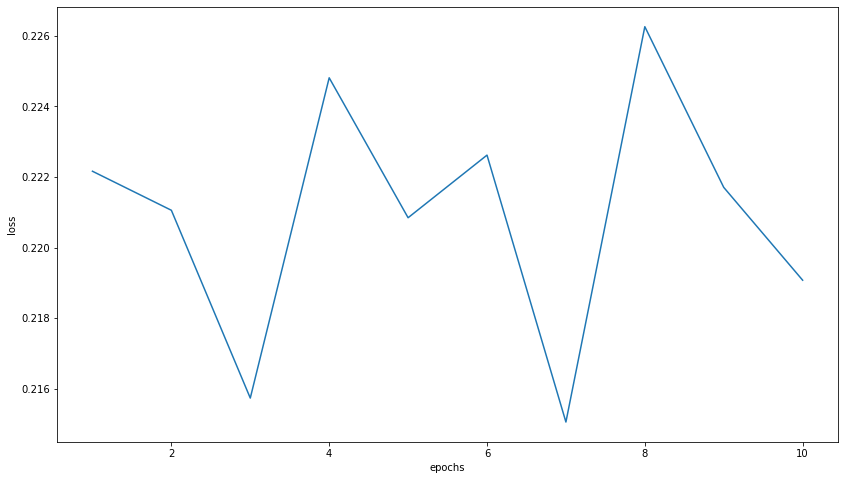

In [27]:
f, a = plt.subplots(1, 1, figsize = (14, 8))

fast_train_loss_plot(loss_unbalanced, a)
fast_train_loss_plot(loss_strtified, a)

## Task

1. Make a dataset balanced: for example select all of the obscene messages, calculate its number and sample from the clean 
messages equal number of examples. **(1)See if it increased your score on toxic messages.** 

As the **additional** task you can modify your dataset sampling during the training/testing. Read about Datasets, DataSamplers and DataLoaders in pytorch. Try to apply them. 


2. Read about RNNs different types (LSTMs and GRUs): 
  https://colah.github.io/posts/2015-08-Understanding-LSTMs/  

  https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21 
  
  **(2)What is the difference between RNN and LSTM? Why do we need LSTM? Explain it in your own words.**  
  
  **(3)What is the difference between LSTM and GRU? Explain it in your own words.** 
  
  
3. Modify your network to make it possible to work with nn.LSTM or nn.GRU layers. (Their outputs may be a little bit defferent from nn.RNN, so be careful to modify your code accordingly). 

4. Compare all of the previous examples: classification with RNN (or LSTM/GRU) and FFNN. **(4)Which one performed better according to the metrics? (5)To the time?**

5. **(6)How dataset imbalancing are influencing your model? Read about dataset imbalancing and about possibilities to handle them. (7)Write down below what can we do with it, or implement a solution.** 
  
  

Please, answer the questions 1-7 and write your answers down below: 

1. Ответ дан немного раньше. Если кратко - помогло. Но этого недостаточно, можно большего добиться.
2. RNN vs LSTM
3. LSTM vs GRU
4. RNN vs FFNN - metrics
5. Исходя из проделанного в этой блокноте, хочется утверждать, что модель RNN учится дольше модели FFNN. Это объясняется сложностью первой структуры...  
6. Интуитивно ясно, что существует прямая зависимость между качеством собранных данных для модели и её итоговыми показателями...
7. Проблему о слабо сбалансированном наборе данных для модели можно решить двумя основными способами. Первым способом будет создание районированной выборки из исходной, вторым - искусственный метод увеличения объёма малого подмножества выборки (по сравнению с количеством остальных данных в ней).